# Demo: Spectral Differentiation (Non-Periodic Case)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

from numpy.fft import fft, ifft

from scipy import sparse

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
# Update 07/18/22: got retina working with updates thanks to 
# https://stackoverflow.com/questions/54312924/what-is-matplotlibs-retina-display-mode
%matplotlib inline
%config InlineBackend.figure_format='retina'

In this demo, we extend spectral differentiation from working on (ncessarily periodic) functions on $S^{1}$ to working on $[-1,1]$: of course, this vastly increases the class of problems that can be handled via a spectral approach. We shall find our old friends the Chebyshev nodes (from the Runge phenomenon demo) indispensible here. Our work is heavily based on Chapters 6 and 8 of Trefethen's spectral methods book. 

## Background Theory 

Consider a continuous function $u(x)\in C\left([-1,1]\right)$. Suppose we mesh $[-1,1]$ using $N+1$ Chebyshev points
$$
x_{j} = \cos\left(\frac{j\pi}{N}\right), \quad j=0,1,2,..., N. 
$$
Note how $x_0 = 1$, $x_N=-1$, so the indexing goes right-to-left. We then represent $u(x)$ by its samples at the grid points: 
$$
u_j = u\left(x_{j}\right). 
$$
Using these samples $\left\{u_{j}\right\}_{j=0}^{N}$, we let $p[u](x)$ denote the unique degree $N$ polynomial interpolant of $u(x)$. 

Throughout this demo, we want to construct good approximations of $u_{x}\left(x_{j}\right)$. We let $W_{j}$ denote these approximate values:
$$
W_{j} =  \partial_{x}\left\{p[u](x)\right\} |_{x=x_{j}} \approx u_{x}\left(x_{j}\right). 
$$
There are two nice methods for computing good-quality values of $W_{j}$ using the samples $\left\{u_{j}\right\}_{j=0}^{N}$ (and by extension $p[u]$). 

### Spatial Point-of-View 

This is the more conceptually straightforward option. We start by noticing that, since $\partial_{x}$ is a linear map on function space, our discrete derivative
$$
D_{N} \colon \left\{u_{j}\right\}_{j=0}^{N} \mapsto \left\{W_{j}\right\}_{j=0}^{N}.
$$
is also a linear map. In particular, we can represent $D_{N}$ as a matrix of size $(N+1)\times (N+1)$. Thus, to find $\left\{W_{j}\right\}_{j=0}^{N}$, it suffices to find the matrix entries
$$
\left(D_{N}\right)_{ij}, \quad i,j=0,1,...,N
$$
and then set 
$$
W_{i} = \sum_{j=0}^{N} \left(D_{N}\right)_{ij} u_{j}. 
$$
Naturally, we call $D_{N}$ the **(Chebyshev) differentiation matrix**. 

Now, we investigate how to find the entries of our differentiation matrix. We start by expressing $p[u](x)$ in a smart way. 

**Definition**

Given a mesh $\left\{x_{j}\right\}_{j=0}^{N} \subseteq [-1,1]$, we define its associated **$j^{\text{th}}$ cardinal function** $p_{j}(x)\in C\left([-1,1]\right)$ by 
\begin{equation}
\left\{
\begin{aligned}
p_{j}(x) &= \frac{1}{a_j}\prod_{k=0 \\ k\neq j}^{N} (x-x_{k}),  
\\
a_{j} &= \prod_{k=0 \\ k\neq j}^{N} (x_{j}-x_{k}) . 
\end{aligned}
\right.
\end{equation}


Note in particular that the cardinal functions satisfy 
$$
p_{j}\left(x_{k}\right) = \delta_{jk}. 
$$
So, cardinal functions are like polynomial $\delta$-functions on our grid. This means that we can express $p[u](x)$ as 
$$
p[u](x) = \sum_{j=0}^{N} u_{j} p_{j}(x). 
$$
Accordingly, 
$$
W_{i} = \partial_{x}\left\{p[u](x)\right\}|_{x=x_{i}} = \sum_{j=0}^{N} u_{j} \partial_{x}\left\{p_{j}(x)\right\}|_{x=x_{i}}. 
$$
We conclude that 
$$
\left(D_{N}\right)_{ij} = \partial_{x}\left\{p_{j}(x)\right\}|_{x=x_{i}}. 
$$
We use the above result to find $D_{N}$ explicitly in two steps. We first derive formulas for $D_{N}$ on a general grid, then we specialize to Chebyshev grids.  

**Lemma**

For a general grid $\left\{x_{j}\right\}_{j=0}^{N}\subseteq [-1,1]$, 

\begin{equation}
\left(D_{N}\right)_{ij} = \begin{cases}
\frac{a_{i}}{a_{j}(x_{i}-x_{j})} \quad \ \ \quad i\neq j,
\\ \\ 
\sum_{k=0 \\ k\neq j}^{N} \frac{1}{x_{j}-x_{k}} \quad i=j. 
\end{cases}
\end{equation}

*Proof*

Logarithmic differentiation shows that 

$$
\partial_{x}p_{j}(x) = p_{j}(x)\sum_{k=0\\ k\neq j}^{N} \frac{1}{x-x_{k}}. 
$$

At first glance, this expression only makes sense at $x_{j}$ and no other grid points. In particular, for $i=j$ we can just plug in to obtain 

$$
\left(D_{N}\right)_{jj} = \partial_{x}p_{j}(x_j) = \delta_{jj} \sum_{k=0\\ k\neq j}^{N} \frac{1}{x_{j}-x_{k}} = \sum_{k=0\\ k\neq j}^{N} \frac{1}{x_{j}-x_{k}}
$$

as claimed. 

Now we turn to the slightly more difficult case $i\neq j$. The apparent singularities in our formula for $\partial_{x}p_{j}(x)$ can actually be removed: if we are interested in evaluating $\partial_{x}p_{j}(x)$ at $x=x_{i}\neq x_{j}$ to compute $\left(D_{N}\right)_{ij}$, we re-write the above as 

\begin{align*}
\partial_{x}p_{j}(x) &= p_{j}(x)\sum_{k=0 \\ k\neq i,j}^{N} \frac{1}{x-x_{k}} + \frac{p_j(x)}{x-x_{i}}
\\
&= p_{j}(x)\sum_{k=0 \\ k\neq i,j}^{N}  \frac{1}{x-x_{k}} + \frac{1}{a_j} \prod_{k=0 \\ k\neq i,j}^{N}(x-x_k).
\end{align*}

From here, the singularity at $x=x_{i}$ has been removed and we can plug in $x=x_{i}$ to obtain 

\begin{align*}
\left(D_{N}\right)_{ij} = \delta_{ij}\sum_{k=0 \\ k\neq i,j}^{N}  \frac{1}{x_{i}-x_{k}} + \frac{1}{a_j} \prod_{k=0 \\ k\neq i,j}^{N}(x_{i}-x_k) = \frac{1}{a_j} \prod_{k=0 \\ k\neq i,j}^{N}(x_{i}-x_k), 
\end{align*}

where we have also used $i\neq j$. The proof is complete upon recalling that 

$$
\frac{a_i}{x_i-x_j} = \frac{1}{x_i-x_j} \prod_{k=0\\ k\neq i}^{N}(x_i-x_k) = \prod_{k=0\\ k\neq i,j}^{N}(x_i-x_k). 
$$

**Lemma**

Define 

$$
c_{i} = \begin{cases} 
2 \quad i=0,N,
\\ \\ 
1 \quad \text{else}. 
\end{cases}
$$

For the Chebyshev grid $\left\{x_{j}\right\}_{j=0}^{N}\subseteq [-1,1]$, we have

\begin{equation}
\left(D_{N}\right)_{ij} = \begin{cases}
\phantom{-}\frac{2N^2+1}{6} \quad \ \ \ \quad i= j =0,
\\ \\
-\frac{2N^2+1}{6} \quad \ \ \ \quad i= j =N,
\\ \\ 
-\frac{x_{j}}{2(1-x_{j}^2)} \quad \ \ \quad 1\leq i= j \leq N-1, 
\\ \\
\frac{c_i}{c_j} \frac{(-1)^{i+j}}{x_i-x_j} \quad \ \ \ \quad \text{else}. 
\end{cases}
\end{equation}

*Proof* 

TODO: fill the proof in! 

### Fourier Point-of-View

We can also execute Chebyhsev spectral differentiation using the DFT. To begin seeing how this works, we need a definition. 

**Definition**

If $u\in C\left([-1,1]\right)$, then we define 
$$
u^{E} \in C\left(S^1\right)
$$
by 
$$
u^{E}(z) = u\left(\text{Re} \ z\right). 
$$
In angular coordinates, 
$$
u^{E}(\theta) = u\left(\cos\theta\right). 
$$

In practice, think of $u^{E}$ as the even extension of $u(x)$ to the entire unit circle. More precisely, recall that any function $u\in C\left([-1,1]\right)$ defines another function on the upper half-circle $\left\{|z|=1, \ \text{Im} \ z \geq0\right\}$ according to 
$$ z \mapsto u\left(\text{Re} \ z\right). $$
$u^{E}$ is then the even extension of this function to the entirety of $S^1$. 

The advantage of working on $S^1$ instead of $[-1,1]$ is that we have access to a Fourier transform on $S^1$, which naturally gives rise to the discrete Fourier transform (DFT) acting on functions samples at the points of uniform mesh of $S^1$. In our demo on spectral differentiation of periodic functions (equivalent to functions on $S^1$), we saw that one could accurately approximate derivatives by taking the DFT of our function samples (implemented via the FFT), multiplying the result entry-wise by the sequence $k\mapsto ik$, and then taking the inverse DFT (implemented via the IFFT). So, numerically evaluating the derivatives of $\partial_{\theta}u^{E}$ to high accuracy is easy. What remains is to show how these approximations translate to approximations of $\partial_{x}u$. 

Let's start by setting up some notation. First, notice that if we're sampling $u(x)$ on $[-1,1]$ using $N+1$ Chebyshev grid points, then we should sample $u^{E}\left(\theta\right)$ using $2N$ grid points uniformly distributed around the circle. The reason why we add extra samples is easy to understand: the samples $u_{j}$ correspond to samples of $u^{E}(\theta)$ at 
$$
\theta_{j} = \frac{j\pi}{N}, \quad j=0,1,...,N,
$$
and since $u^{E}$ is even with respect to reflections about $\left\{\theta=0\right\}$ these samples also give the values of $u^{E}$ at
$$
\theta_{j} = \frac{j\pi}{N}, \quad j=N+1,...,2N-1
$$
(remember not to double-count $\theta=0,\pi$ mod $2\pi$!), for a total of $2N$ samples of $u^{E}$. That is, we have 
$$
u^{E}_{j} = \begin{cases}
u_{j} \quad \quad \ \ j=0,...,N
\\
u_{2N-j} \quad j=N+1,...,2N-1
\end{cases}
$$
or, in array notation,
$$ \left\{u^{E}_{j}\right\}_{j=0}^{2N-1} = \left[u_0, u_1,...,u_{N-1}, u_{N}, u_{N-1}, u_{N-2}, ..., u_{2}, u_{1}\right].$$
Note that, in the code below, we denote $u^{E}_{j}$ by $\texttt{V[j]}$.

Now that we have set up our conventions for sampling the extension $u^{E}$, we get into the meat of the differentiation algorithm. The DFT of these samples is 
$$
\left(\widehat{u^{E}}\right)_{k} = \sum_{j=0}^{2N-1} e^{-ik\frac{j\pi}{N}} u^{E}_{j}, \quad k=0, ..., 2N-1. 
$$ 
As we have learned already, we have 
$$
\partial_{\theta}u^{E}\left(\frac{j\pi}{N}\right) \approx U_{j} \doteq \left(\left\{ik\left(\widehat{u^{E}}\right)_{k}\right\}_{k=0}^{2N-1}\right)^{\vee}
$$
with high accuracy: recall that the $\vee$ denotes the inverse DFT: 
$$
{v}_{\ell}^{\vee} = \frac{1}{2N} \sum_{k=0}^{2N-1}e^{ik\frac{\ell \pi}{N}} v_{k}. 
$$
Note that 
$$
U_{j} = \partial_{\theta}\left\{p\left[u^{E}\right]\right\}\big|_{\theta=\frac{j\pi}{N}}, 
$$
where similarly to the purely spatial case we let $p\left[u^{E}\right]$ denote the trigonometric polynomial interpolating $u^{E}$ on our chosen uniform mesh. As long as $\theta\notin \pi \mathbb{Z},$ we have by the Chain Rule that
$$
\partial_{x} p[u](x) = \frac{\partial_{\theta}\left\{p\left[u^{E}\right]\right\}}{\partial_{x}\theta} = -\frac{\partial_{\theta}\left\{p\left[u^{E}\right]\right\}}{\sin\theta}. 
$$
Fixing $j=1,...,N-1$, plugging
$$
\theta= \frac{j\pi}{N}
$$
into the above, and using Pythagoras' theorem gives
$$
\partial_{x}\left\{ p[u](x)\right\}|_{x=x_{j}} = \frac{-U_{j}}{\sqrt{1-x_j^2}}. 
$$
By the collocation principle for estimating derivatives, this means we should set 
$$
u_{x}\left(x_{j}\right) \approx W_{j} = \frac{-U_{j}}{\sqrt{1-x_j^2}} .
$$
This is great news: the $W_{j}$'s can be computed by simply extending our samples of $u(x)$, then following the recipe for Fourier spectral differentiation. 

Unfortunately, the above analysis fails at the boundary points $x=\pm 1$, corresponding to $\theta=0,\pi$ or $j=0, N$. We need to be a little more clever to estimate the boundary values of $u_{x}$. Following Trefethen, we proceed in a roundabout but inspired fashion. This begins by recalling the following: 

**Definition**

Given $n=0,1,2,...$, we define the corresponding **Chebyshev polynomial** $T_{n}(x)\in C\left([-1,1]\right)$ by 
$$
T_n\left(\cos\theta\right) = \cos\left(n\theta\right) \quad \forall \ \theta\in [-\pi,\pi). 
$$

We have already encountered the Chebyshev polynomials before when studying interpolation theory. 

Recalling that $p[u]$ denotes the $(N+1)$-point interpolant of $u(x)$ at the Chebyshev nodes, we know there are unique $a_{0}, ..., a_{N}$ such that 
$$
p[u] = \sum_{n=0}^{N} a_{n} T_{n}(x). 
$$
Additionally, by the defining property of Chebyshev polynomials, we have 
$$
p[u]^{E}(\theta) = \sum_{n=0}^{N} a_{n} \cos\left(n\theta\right).
$$
Therefore, the extension of our interpolant is little more than a truncated Fourier cosine series. By uniqueness of trigonometric interpolants (the finite version of Fourier series uniqueness), we must have 
$$
p[u]^{E}(\theta) = p\left[u^{E}\right](\theta)
$$
hence 
$$
\sum_{n=0}^{N} a_{n} \cos\left(n\theta\right) = \frac{1}{2N} \sum_{k=0}^{2N-1} e^{ik\theta}\left(\widehat{u^{E}}\right)_{k} = \frac{1}{2N}\left\{\left(\widehat{u^{E}}\right)_{0} + 2\sum_{k=1}^{N-1} \left(\widehat{u^{E}}\right)_{k} \cos(k\theta)+ \left(\widehat{u^{E}}\right)_{N}\right\}.
$$

Comparing coefficients gives 

$$
a_{n} = \begin{cases}
\frac{1}{2N} \left(\widehat{u^{E}}\right)_{n} \quad n=0,N,
\\ \\ 
 \frac{1}{N}\left(\widehat{u^{E}}\right)_{n} \quad \ \text{else}. 
\end{cases}
$$
From a computational perspective, these formulas are good news: we have computed all the $\left(\widehat{u^{E}}\right)_{n}$'s when evaluating the interior derivative values, so no substantial extra computer work has to be done to determine the $a_{n}$'s. 


Thus we have shown that 
$$
p[u](x) = \frac{1}{N}\left[\frac12\left(\widehat{u^{E}}\right)_{0} + \sum_{k=1}^{N-1} \left(\widehat{u^{E}}\right)_{n}T_{n}(x) +\frac12\left(\widehat{u^{E}}\right)_{N} \right]
$$
but this is not quite enough to estimate $u_{x}\left(\pm 1\right)$. 
Returning to our Chain Rule expression for $\partial_{x}p[u]$, we find 
$$
\partial_{x} p[u](x) = \left(1-x^2\right)^{-\frac12}\sum_{n=1}^{N-1} n\left(\widehat{u^{E}}\right)_{n} \sin\left(n\cos^{-1}(x)\right)+ \frac12 N\left(\widehat{u^{E}}\right)_{N}\sin\left(N\cos^{-1}(x)\right) .
$$
We thus turn to computing 
$$
\lim_{x\rightarrow \pm 1^{\mp}}\frac{\sin\left(n\cos^{-1}(x)\right) }{\sqrt{1-x^2}} \quad \forall  \ n =1,2,...,N.
$$
A simple computation with L'Hospital's rule gives 
$$
\lim_{x\rightarrow \pm 1^{\mp}}\frac{\sin\left(n\cos^{-1}(x)\right) }{\sqrt{1-x^2}} = \begin{cases}
\phantom{(-1)^{n+1}}n  \quad \text{if} \quad x\rightarrow +1^{-}
\\ \\
(-1)^{n+1}n\quad \text{if} \quad x\rightarrow -1^{+}. 
\end{cases}
$$
This in turn yields the estimates
\begin{align*}
\partial_{x}u\left(x_0\right) &\approx W_{0} =  \frac{1}{N}\left\{\frac12 N^2 \left(\widehat{u^{E}}\right)_{N} + \sum_{n=1}^{N-1}n^2\left(\widehat{u^{E}}\right)_{n}  \right\}
\\
\partial_{x}u\left(x_N\right) &\approx W_{N} = - \frac{1}{N}\left\{\frac12 (-1)^{N} N^2 \left(\widehat{u^{E}}\right)_{N} + \sum_{n=1}^{N-1}(-1)^{n}n^2\left(\widehat{u^{E}}\right)_{n}  \right\}. 
\end{align*}
Combining the above two expressions with the interior derivatives obtained earlier (in terms of the $U_{j}$'s), we have completely described our DFT-based scheme for Chebyshev differentiation. 

TODO: some discussion presenting pros and cons of spatial versus FFT-based Chebyshev differentiation? Other remarks on efficiency ie. using cosine transforms instead of full FFTs etc? 

## Numerical Examples

First, we define the function 
$$ u(x) = e^{x}\sin(5x) $$
whose derivative $u_{x}$ we seek to approximate. Of course, for such a nice function we know its derivative exactly,
$$
u_{x}(x) = u(x) + 5e^{x}\cos(5x),
$$
so computing the error in approximation of $u_{x}$ is easy. 

TODO: add options for rougher functions so one can investigate rates of convergence etc. 

In [2]:
def test_fnc(x):
    
    out = np.exp(x)*np.sin(5.*x)
    
    return out

def test_fnc_prime(x):
    
    out = test_fnc(x) + 5.*np.exp(x)*np.cos(5.*x)
        
    return out 

We need subroutines for assembling Chebyshev grids and Chebyshev differentiation matrices. The grid can be assembled using a modification of the function $\texttt{chebnodes}$ we wrote when examining the Runge phenomenon. 

In [3]:
def chebnodes(N):
# spits out an array of the n^th Chebyshev nodes in [-1,1]. NOTE: the output is arranged so 
# x[-1] = -1, x[0]=1. In other words, the grid is presented right-to-left instead.
# This is consistent with the convention in Trefethen's book

    theta = (np.pi/(N))*np.arange(0,N+1, dtype=int)
    
    x = np.cos(theta)
    
    return x

Using the grid generation function $\texttt{chebnodes}$, we can create our two differentiation matrices. We start with the finite difference differentiation matrix on the Chebyshev grid. 

In [4]:
def D_fd(N):
    # finite difference differentiation matrix
    
    # TODO: clean this and try to vectorize as much as possible!
    
    # first get Cheb nodes
    x = chebnodes(N)
    
    # grid spacings 
    h = np.zeros(N+1, dtype='float')
    
    h[0:-1] = x[0:-1]-x[1:]
        
    h[-1] = x[-1]-x[-2]   
        
    # forward fd until we hit the left endpoint x=-1
    D = sparse.diags([1.*np.ones(N+1),-1*np.ones(N)], [0,1], shape=(N+1,N+1)).toarray()
    
    # backward fd at x=-1
    D[-1,-1] = 1. 
    
    D[-1,-2] = -1. 
    
    for n in np.arange(0,N+1):
    
        D[n,:]/=h[n]
    
    return D

Now, we define the Chebsyhev differentiation matrix. This is a little more difficult than coding up the finite difference matrix, but it still does not use anything more complicated than our grid generator $\texttt{chebnodes}$ and NumPy's basic array manipulation functions. 

In [5]:
def chebdiff(N):
# spits out N+1 x N+1 Chebyshev differentiation matrix 
# TODO: this is pretty much just copied from Trefethen and Pythonized... 
# make sure you understand what is actually going on!
    
    c = np.ones([N+1,1])
    
    c[0] = 2.
    
    c[-1] = 2. 
    
    c = (c*(-1)**np.arange(0,N+1)).T
    
    x = chebnodes(N)
        
    X = np.tile(x,[N+1,1])
    
    dX = X - X.T
        
    D = c*(1./c.T)/(dX + np.identity(N+1))
        
    D -= np.diag(np.sum(D.T, axis=1))
    
    return D.T

In [6]:
xx= np.linspace(-1, 1, 100)
uu= test_fnc(xx)

N = 20

x = chebnodes(N)
u = test_fnc(x)
ux = test_fnc_prime(x) # exact derivative evaluated at grid points

D = chebdiff(N)

error = np.abs(D@u - ux)

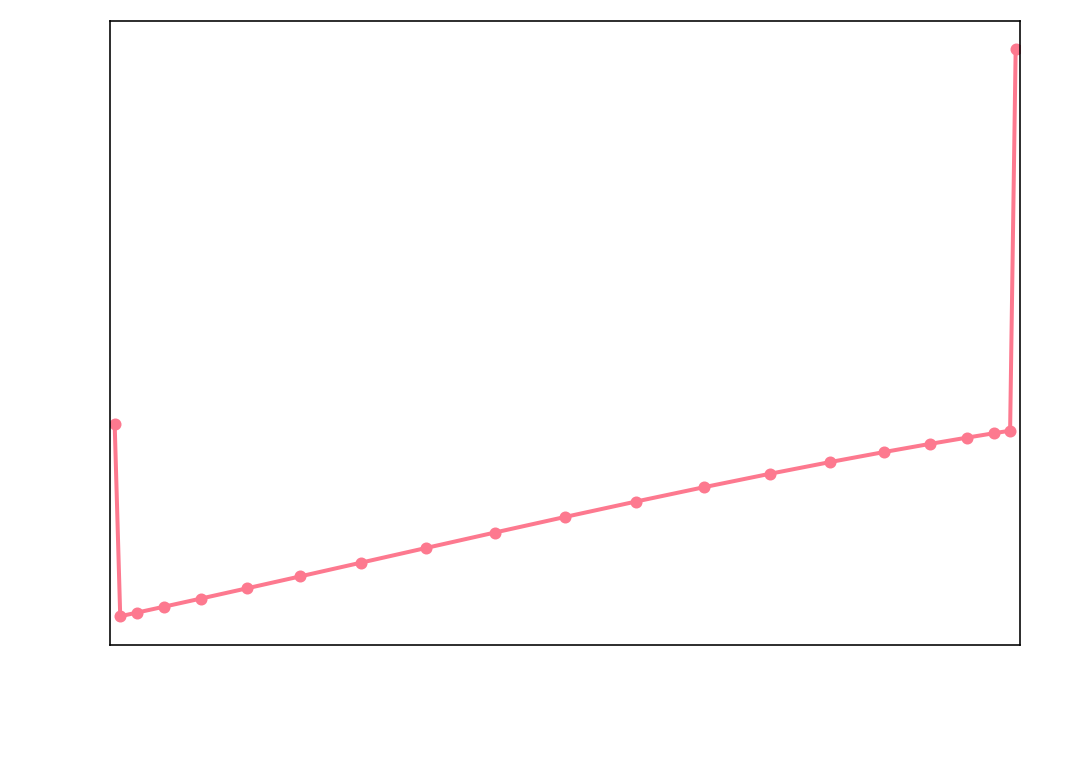

In [7]:
fig, ax =plt.subplots()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.plot(x, 1e10*error, '.', markersize='10', color='xkcd:carnation', ) 
plt.plot(x, 1e10*error, color='xkcd:carnation', linewidth='2') 

plt.xlabel(r"$x$", fontsize=26, color = 'w')
plt.ylabel(r"$10^{10}\times$ Error", fontsize=26, color = 'w')

plt.xlim([-1.01,1.01])

#plt.ticklabel_format(axis='both', style='sci', scilimits=(0,10))

plt.tick_params(axis='x', which='both', top='False', color = 'w')
plt.xticks(fontsize=18, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='False', color = 'w')
plt.yticks(fontsize=18, rotation=0, color = 'w')

ax.yaxis.get_offset_text().set_fontsize(18)
ax.yaxis.get_offset_text().set_color('w')

plt.tight_layout()

fig.set_size_inches(8, 6)
#plt.rcParams['figure.dpi'] = 600
    
plt.show()

TODO: some discussion on the errors in this picture, incl. why they accumulate on the boundary. This is probably because, even when using Chebyshev grids to counteract the Runge phenomenon, the worst interpolation errors still concentrate on the boundary (ie. there is still near-boundary oscillation, BUT it's not as bad as that encoutnered with uniform grid spacing). This also justifies why we should choose the particular point where we evaluate accuracy in approximation of $u_{x}(x)$ to be one of the boundary points! 

In [8]:
grid_n = np.arange(4,41)

errors_fd = np.ones_like(grid_n, dtype=float)

errors_spec = np.ones_like(grid_n, dtype=float)

ux_exact = test_fnc_prime(1)

for n in np.arange(0,np.size(grid_n)): 
    
    N = grid_n[n]

    x = chebnodes(N)
        
    u = test_fnc(x)
        
    fd_estimate = D_fd(N)@u
    
    spec_estimate = chebdiff(N)@u
        
    errors_fd[n] = np.abs(ux_exact-fd_estimate[0])
        
    errors_spec[n] = np.abs(ux_exact-spec_estimate[0])
    # note that were computing accuracy in the approximation of u_{x}(1), and since
    # by default chebnodes reads right-to-left, we take out the 0^th entry of fd_estiamte and 
    # spec_estimate instead of the -1^th entry

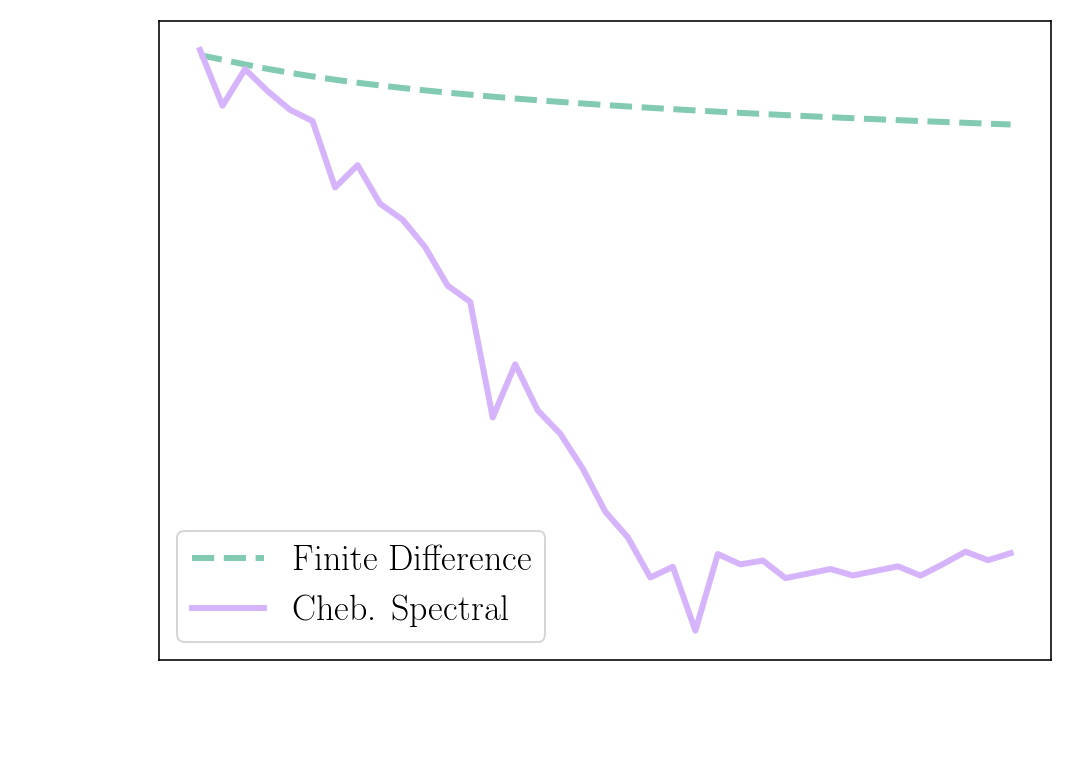

In [9]:
fig, ax =plt.subplots()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
        
plt.semilogy(grid_n, errors_fd, color='xkcd:pale teal', linewidth='3', linestyle='dashed', label=r"Finite Difference")

plt.semilogy(grid_n, errors_spec, color='xkcd:light violet', linewidth='3', linestyle='solid',label=r"Cheb. Spectral")

#plt.xlim([5,40])

ax.legend(fontsize=18, loc='best')

plt.xlabel(r"Number of Grid Sites $N$", fontsize=26, color = 'w')
plt.ylabel(r"Error", fontsize=26, color = 'w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=18, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=18, rotation=0, color = 'w')
#ax.locator_params(axis='y', nbins=6)
#ax.locator_params(axis='x', nbins=6)

plt.tight_layout()

fig.set_size_inches(8, 6)
#plt.rcParams['figure.dpi'] = 600
    
plt.show()

We can also perform Chebyshev differentiation using the FFT. The following script, adapted from our periodic spectral differentiation routine, executes this. 

 TODO: discuss efficiency and performance vs the purely spatial method. 

In [10]:
def chebdiff_fft(u):
    
    N = np.shape(u)[0] - 1
        
    u = u.reshape((N+1,)) # change to a column vector just in case
    
    # extend samples evenly the entire unit circle
    V = np.zeros(2*N, dtype=float)
    
    V[0:N+1] = u
    
    V[N+1:] = np.flip(u[1:N])
    
    # take fft of even extension        
    Vhat = fft(V+0j)
    
    # get symbol of partial_x = ik
    partialx = 1j*np.zeros(2*N, dtype=float)
    partialx[0:N+1] = 1j*np.arange(0,N+1)
    partialx[N+1:] = 1j*np.arange(-N+1,0,1) 
        
    # differentiate even extension, then ifft. Only keep part of that is relevant ie. restrict
    # to the top half of the unit circle
    W = np.real(ifft(partialx*Vhat)[0:N+1])
    
    # also discard imaginary part of Vhat
    Vhat = np.real(Vhat)
    
    # finally, reconstruct \partial_{x}u at the Chebyshev grid points. 
    ux = np.zeros(N+1, dtype=float)
    
    # handle interior points first w/ easy reconstruction formula
    x = chebnodes(N)[1:N]
    
    ux[1:N] = -W[1:N]/np.sqrt(1.-x**2)
    
    # now deal with tougher boundary points. 
    indices = np.arange(1,N)
    
    ux[0] = np.sum((indices**2)*Vhat[1:N], axis=0)
    
    ux[0] += 0.5*((N**2)*Vhat[N]) # append last piece of sum
    
    ux[0]*= 1./(N) 
    # note: if we used Trefethen's fft/ifft conventions this factor would be different!
    # But his convention disagrees with scipy fft defaults so we don't use it here. 
         
    ux[N] = -np.sum(((-1.)**(indices))*(indices**2)*Vhat[1:N], axis=0)
    
    ux[N] += -0.5*(((-1.)**N) *(N**2)*Vhat[N])# append last piece of sum
    
    ux[N]*= 1./(N)
    
    # reshape for safety
    ux.reshape((N+1,))
        
    return ux

In [11]:
# TODO: print absolute error when handling Chebyshev diff via both methods. 

In [12]:
grid_n = np.arange(4,41)

errors_fd = np.ones_like(grid_n, dtype=float)

errors_spec = np.ones_like(grid_n, dtype=float)

ux_exact = test_fnc_prime(1)

for n in np.arange(0,np.size(grid_n)): 
    
    N = grid_n[n]

    x = chebnodes(N)
        
    u = test_fnc(x)
        
    fd_estimate = D_fd(N)@u
    
    spec_estimate = chebdiff_fft(u)
        
    errors_fd[n] = np.abs(ux_exact-fd_estimate[0])
        
    errors_spec[n] = np.abs(ux_exact-spec_estimate[0])
    # note that were computing accuracy in the approximation of u_{x}(1), and since
    # by default chebnodes reads right-to-left, we take out the 0^th entry of fd_estiamte and 
    # spec_estimate instead of the -1^th entry

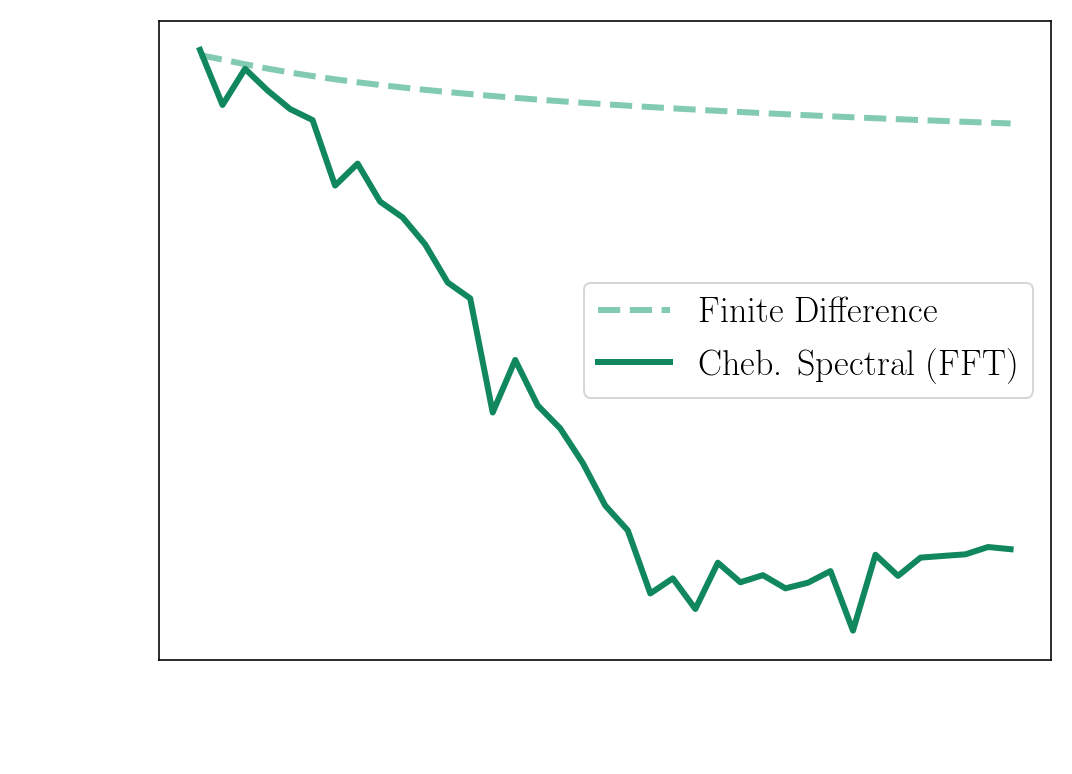

In [14]:
fig, ax =plt.subplots()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
        
plt.semilogy(grid_n, errors_fd, color='xkcd:pale teal', linewidth='3', linestyle='dashed', label=r"Finite Difference")

plt.semilogy(grid_n, errors_spec, color='xkcd:dark sea green', linewidth='3', linestyle='solid',label=r"Cheb. Spectral (FFT)")

#plt.xlim([5,40])

ax.legend(fontsize=18, loc='best')

plt.xlabel(r"Number of Grid Sites $N$", fontsize=26, color = 'w')
plt.ylabel(r"Error", fontsize=26, color = 'w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=18, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=18, rotation=0, color = 'w')
#ax.locator_params(axis='y', nbins=6)
#ax.locator_params(axis='x', nbins=6)

plt.tight_layout()

fig.set_size_inches(8, 6)
#plt.rcParams['figure.dpi'] = 600
    
plt.show()

From this figure, it appears that spatial versus FFT-based Chebyshev differentiation perform similarly for our simple test problem. 